# Imports

In [1]:
import cobra
import numpy as np
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis
from cobra.util.solver import linear_reaction_coefficients

from full_ecosystem import Ecosystem
from eco_utils import *
from cobra import Metabolite, Reaction, Model
from cobra.util.array import create_stoichiometric_matrix
from cobra.util.solver import linear_reaction_coefficients
from cobra.flux_analysis import flux_variability_analysis


# _E. coli_ synthetic community example

In this example a synthetic community of two _E. coli_ auxotrophic for different amino acids (leucine and lysine) is constructed to test this method

## _E. coli_ model load

In [2]:
data_dir = 'models/'
model = cobra.io.read_sbml_model("%s%s" % (data_dir, "iAF1260.xml"))

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2760359
Academic license 2760359 - for non-commercial use only - registered to ma___@ug.uchile.cl


In [3]:
model.reactions.BIOMASS_Ec_iAF1260_core_59p81M.reaction

'0.000223 10fthf_c + 0.000223 2ohph_c + 0.5137 ala__L_c + 0.000223 amet_c + 0.2958 arg__L_c + 0.2411 asn__L_c + 0.2411 asp__L_c + 59.984 atp_c + 0.004737 ca2_c + 0.004737 cl_c + 0.000576 coa_c + 0.003158 cobalt2_c + 0.1335 ctp_c + 0.003158 cu2_c + 0.09158 cys__L_c + 0.02617 datp_c + 0.02702 dctp_c + 0.02702 dgtp_c + 0.02617 dttp_c + 0.000223 fad_c + 0.007106 fe2_c + 0.007106 fe3_c + 0.2632 gln__L_c + 0.2632 glu__L_c + 0.6126 gly_c + 0.2151 gtp_c + 54.462 h2o_c + 0.09474 his__L_c + 0.2905 ile__L_c + 0.1776 k_c + 0.01945 kdo2lipid4_e + 0.4505 leu__L_c + 0.3432 lys__L_c + 0.1537 met__L_c + 0.007895 mg2_c + 0.000223 mlthf_c + 0.003158 mn2_c + 0.003158 mobd_c + 0.01389 murein5px4p_p + 0.001831 nad_c + 0.000447 nadp_c + 0.011843 nh4_c + 0.02233 pe160_c + 0.04148 pe160_p + 0.02632 pe161_c + 0.04889 pe161_p + 0.1759 phe__L_c + 0.000223 pheme_c + 0.2211 pro__L_c + 0.000223 pydx5p_c + 0.000223 ribflv_c + 0.2158 ser__L_c + 0.000223 sheme_c + 0.003948 so4_c + 0.000223 thf_c + 0.000223 thmpp_c + 0.

# Construction of auxotrophic _E. coli_ models for 2 member community

In [4]:
exports = ['EX_leu__L_e','EX_lys__L_e'] 

### **ec_minus_lys**: 

_E. coli_ which requires to have lysine supplemented in media or by other member of the community

In [5]:
ec_minus_lys = model.copy()

Read LP format model from file /tmp/tmp691as4rn.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros


In [6]:
ec_minus_lys.reactions.get_by_id('DAPDC')

Reaction identifier,DAPDC
Name,Diaminopimelate decarboxylase
Memory address,0x74e86df19630
Stoichiometry,"26dap__M_c + h_c --> co2_c + lys__L_c Meso-2,6-Diaminoheptanedioate + H+ --> CO2 CO2 + L-Lysine"
GPR,b2838
Lower bound,0.0
Upper bound,999999.0


In [7]:
ec_minus_lys_bound_modifications = {'DAPDC':(0,0),
                            'EX_lys__L_e' : (-1000,1000),
                                   } 
for rid in ec_minus_lys_bound_modifications:
    r = ec_minus_lys.reactions.get_by_id(rid)
    r.bounds = ec_minus_lys_bound_modifications[rid]

Check lysine requirement

In [8]:
ec_minus_lys.slim_optimize()

0.767894558930575

In [9]:
flux_variability_analysis(ec_minus_lys, exports, fraction_of_optimum=0.1)

,minimum,maximum
EX_leu__L_e,0.0,5.461462
EX_lys__L_e,-1000.0,-0.026354


### **ec_minus_leu**:


_E. coli_ requires Leucine due to knockout on IPPS (2-isopropylmalate synthase) reaction

In [10]:
ec_minus_leu = model.copy()

Read LP format model from file /tmp/tmp92al5u8_.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros


In [11]:
ec_minus_leu.reactions.get_by_id('IPPS')

Reaction identifier,IPPS
Name,2-isopropylmalate synthase
Memory address,0x74e88f320f70
Stoichiometry,3mob_c + accoa_c + h2o_c --> 3c3hmp_c + coa_c + h_c 3-Methyl-2-oxobutanoate + Acetyl-CoA + H2O H2O --> 3-Carboxy-3-hydroxy-4-methylpentanoate + Coenzyme A + H+
GPR,b0074
Lower bound,0.0
Upper bound,999999.0


In [12]:
ec_minus_leu_bound_modifications = {'IPPS':(0,0),
                            'EX_leu__L_e' : (-1000,1000),
                                   } 
for rid in ec_minus_leu_bound_modifications:
    r = ec_minus_leu.reactions.get_by_id(rid)
    r.bounds = ec_minus_leu_bound_modifications[rid]

Check leucine requirement

In [13]:
ec_minus_leu.slim_optimize()

0.7763435343183174

In [14]:
flux_variability_analysis(ec_minus_leu, exports, fraction_of_optimum=0.1)

,minimum,maximum
EX_leu__L_e,-0.349743,-0.034974
EX_lys__L_e,0.000000,5.492299


## Store individual models and generate ecosystem object

In [15]:
member_models = { 'ec_minus_lys':ec_minus_lys,
                  'ec_minus_leu':ec_minus_leu         
                 }

for model_id in member_models:
    filename = "%s.xml" % (model_id)
    member_model = member_models[model_id]
    cobra.io.write_sbml_model(member_model, filename)
    print('model %s stored' % model_id)

model ec_minus_lys stored
model ec_minus_leu stored


In [16]:
member_models = [ec_minus_lys, ec_minus_leu]

In [17]:
eco2 = Ecosystem(models = member_models, prefixes=['eco_lys', 'eco_leu'], 
                     community_name = 'eco2', community_id = 'eco2', solver='gurobi')

0. Copying member models ...
Read LP format model from file /tmp/tmpk9b0ah9_.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Read LP format model from file /tmp/tmp3cai5277.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
1. Storing exchanged metabolites information ...
2. Updating member model objects ids ...
3. Storing member objectives ...
4. Merging member models ...
Read LP format model from file /tmp/tmpxlziap92.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Read LP format model from file /tmp/tmp5ykidofp.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
{'eco_lys_BIOMASS_Ec_iAF1260_core_59p81M': 1.0}
{'eco_leu_BIOMASS_Ec_iAF1260_core_59p81M': 1.0}
5. Creating pool compartment, metabolites and reactions ...
6. Updating compartment names ...
Done. Community model created
Created community model from 2 member models:
General stats:
model (0):
	 id = iAF1260, name = None , prefix= eco_l

### Set bounds simulation

From Zhang et al., (2014), uptake of single cultured strains (Table 1):
- dlysA: 0.161 mmol/gDW/h
- dleuA: 0.220 mmol/gDW/h

Table S1: glc uptake rate by the community: 6.025 mmol/gDW/h.

Scenarios defined in this work:
- sim_glc_cons_AA_prod_no_AA: constrained glucose entry (-10), as well as biological constraint of 10. No leucine or lysine supplementation
- sim_glc_cons_AA_prod_001_AA: same conditions of previous scenario but supplementation of 0.01 of leucine and lysine

In [18]:
case = 'sim_glc_cons_AA_prod_no_AA'
eco2.set_pool_bounds({'glc__D_e':(-10,1000)}, bioCons = -10)
eco2.set_pool_bounds({'lys__L_e':(0,1000)}, bioCons = -0.161)
eco2.set_pool_bounds({'leu__L_e':(0,1000)}, bioCons = -0.22)
eco2.set_pool_bounds({'o2_e':(-15,1000)}, bioCons = -15)

eco2.cmodel.reactions.eco_leu_EX_lys__L_e.upper_bound = 0.2
eco2.cmodel.reactions.eco_lys_EX_leu__L_e.upper_bound = 0.2

In [19]:
eco2.cmodel.optimize()

,fluxes,reduced_costs
eco_lys_ACGAM1PPpp,0.0,0.000000
eco_lys_2AGPA140tipp,0.0,0.000000
eco_lys_EX_acser_e,0.0,0.000000
eco_lys_2AGPA141tipp,0.0,0.000000
eco_lys_2AGPA160tipp,0.0,0.000000
...,...,...
EX_lys__L_e,0.0,-0.132534
EX_lyx__L_e,0.0,0.000000
EX_mal__D_e,0.0,0.000000
EX_mal__L_e,0.0,0.000000


In [20]:
eco2.cmodel.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e_pool,EX_ca2_e,0.003336,0,0.00%
cl_e_pool,EX_cl_e,0.003336,0,0.00%
cobalt2_e_pool,EX_cobalt2_e,0.002224,0,0.00%
cu2_e_pool,EX_cu2_e,0.002224,0,0.00%
fe2_e_pool,EX_fe2_e,0.005318,0,0.00%
fe3_e_pool,EX_fe3_e,0.005004,0,0.00%
glc__D_e_pool,EX_glc__D_e,10,6,100.00%
k_e_pool,EX_k_e,0.1251,0,0.00%
mg2_e_pool,EX_mg2_e,0.00556,0,0.00%
mn2_e_pool,EX_mn2_e,0.002224,0,0.00%


In [21]:
eco2.set_cluster_reactions()

Missing FCA results
Using non-blocked reactions only
Total reactions considered for fva and clustering: 3159


### Compute grid

In [22]:
eco2.build_grid(numPoints = 10, expand = True, drop_zero=True, ignore_maint = True)

Maximum community:0.8575949100130473
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
[0.         0.09528832 0.19057665 0.28586497 0.38115329 0.47644162
 0.57172994 0.66701826 0.76230659 0.85759491]
[[[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
   0.66666667 0.77777778 0.88888889 1.        ]
  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
   0.66666667 0.77777778 0.88888889 1.        ]
  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
   0.66666667 0.77777778 0.88888889 1.        ]
  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
   0.66666667 0.77777778 0.88888889 1.        ]
  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
   0.66666667 0.77777778 0.88888889 1.        ]
  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
   0.66666667 0.77777778 0.88888889 1.        ]
  [0.         0.11111111 0.22222222

In [23]:
eco2.get_member_reactions()
eco2.get_points_distribution()

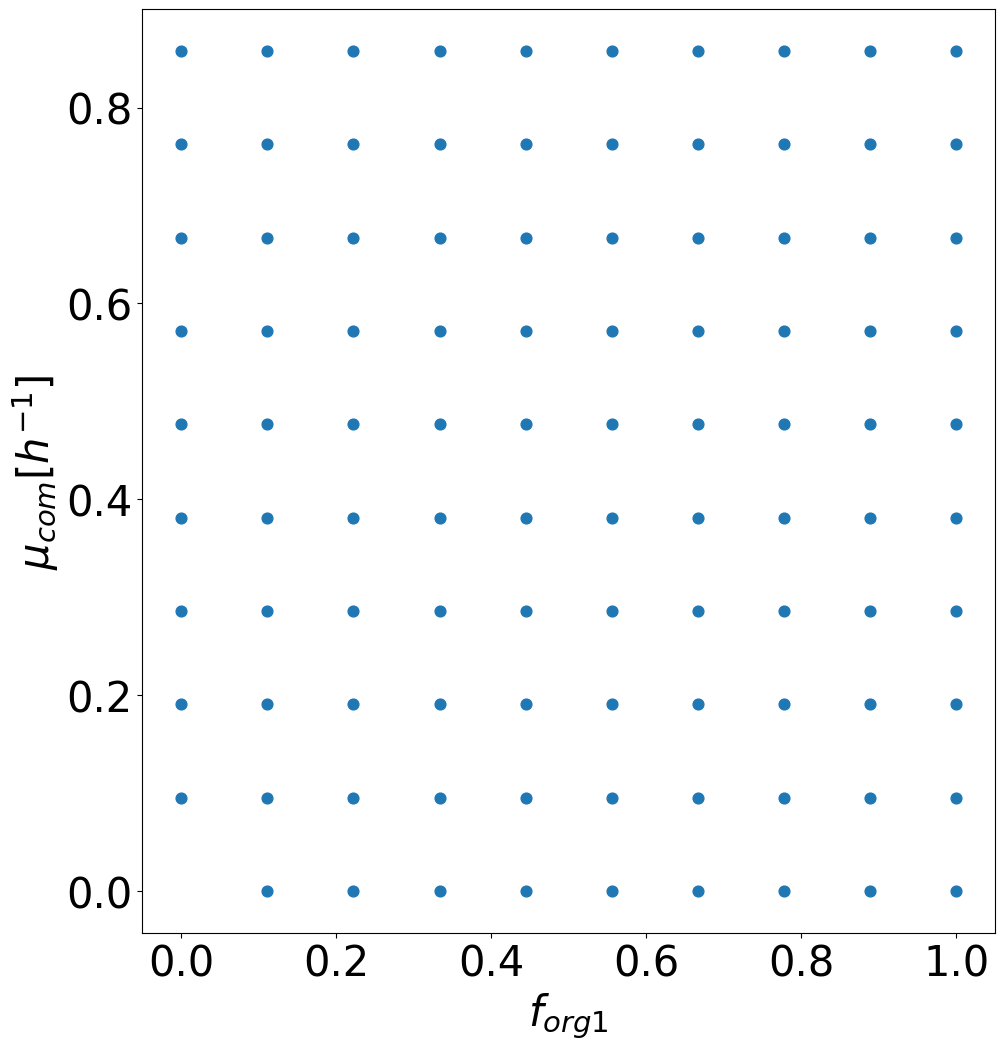

In [24]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

eco2.plot_2D_slice(prefixes=[], fixed_values=[], parent_cmap='tab20',s=60, figsize=(11,12), 
                         to_plot = None, show_edge=False,frac_prefix= None,
                            xlabel = '$f_{org1}$',
                            ylabel ='$\mu_{com}[h^{-1}]$', saveFile = 'grid')

In [25]:
eco2.analyze_grid()

point test: [[0.11111111 0.        ]
 [0.22222222 0.        ]
 [0.33333333 0.        ]
 [0.44444444 0.        ]
 [0.55555556 0.        ]
 [0.66666667 0.        ]
 [0.77777778 0.        ]
 [0.88888889 0.        ]
 [1.         0.        ]
 [0.         0.09528832]
 [0.11111111 0.09528832]
 [0.22222222 0.09528832]
 [0.33333333 0.09528832]
 [0.44444444 0.09528832]
 [0.55555556 0.09528832]
 [0.66666667 0.09528832]
 [0.77777778 0.09528832]
 [0.88888889 0.09528832]
 [1.         0.09528832]
 [0.         0.19057665]
 [0.11111111 0.19057665]
 [0.22222222 0.19057665]
 [0.33333333 0.19057665]
 [0.44444444 0.19057665]
 [0.55555556 0.19057665]
 [0.66666667 0.19057665]
 [0.77777778 0.19057665]
 [0.88888889 0.19057665]
 [1.         0.19057665]
 [0.         0.28586497]
 [0.11111111 0.28586497]
 [0.22222222 0.28586497]
 [0.33333333 0.28586497]
 [0.44444444 0.28586497]
 [0.55555556 0.28586497]
 [0.66666667 0.28586497]
 [0.77777778 0.28586497]
 [0.88888889 0.28586497]
 [1.         0.28586497]
 [0.         

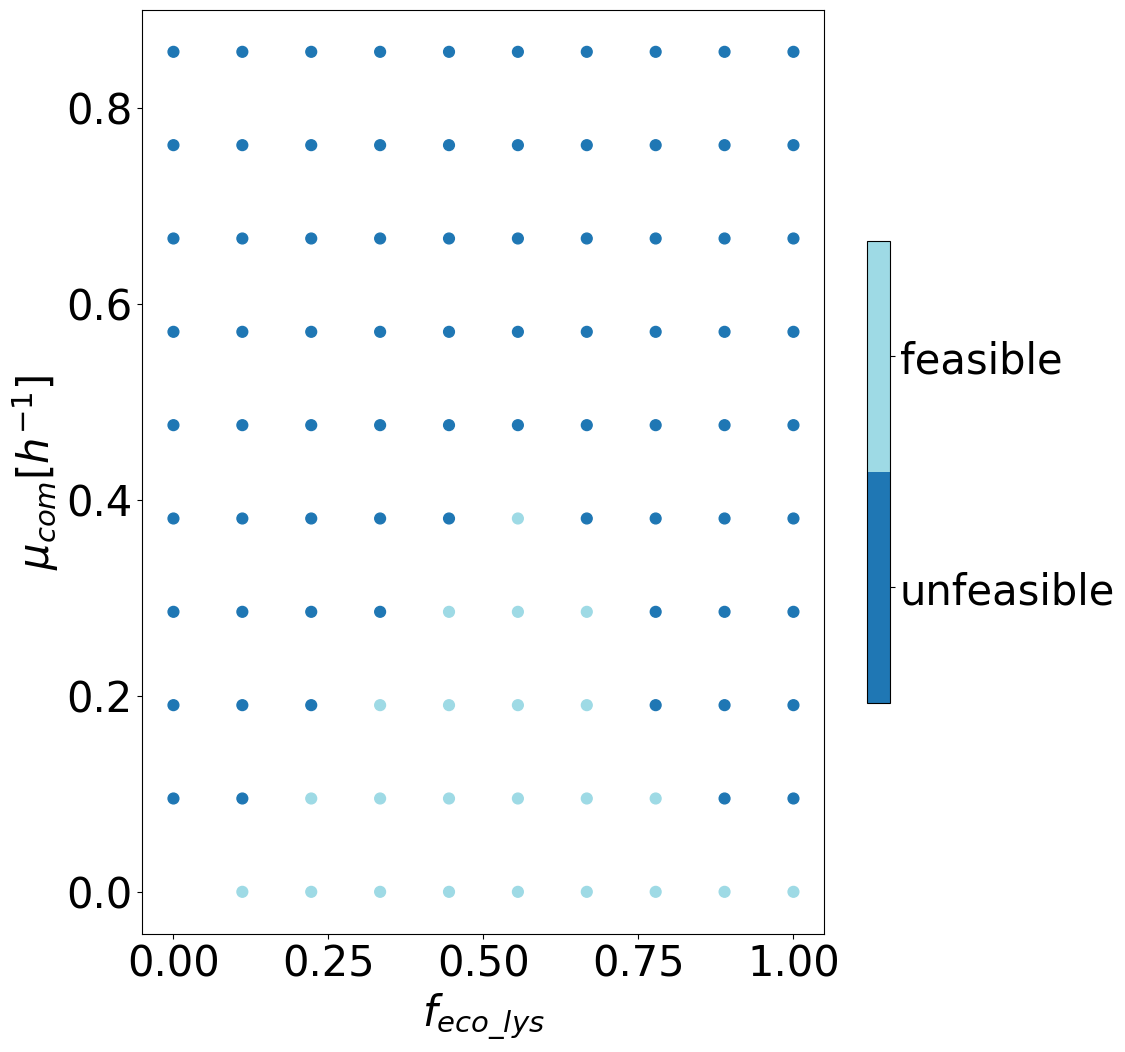

In [26]:
eco2.plot_2D_slice(prefixes=[], fixed_values=[], parent_cmap='tab20',s=60, figsize=(11,12), 
                         to_plot = 'feasible', show_edge=False,frac_prefix= None,
                            xlabel = '$f_{eco\_lys}$',
                            ylabel ='$\mu_{com}[h^{-1}]$', saveFile = 'grid')

In [27]:
eco2.objectives

[{'eco_lys_BIOMASS_Ec_iAF1260_core_59p81M': 1.0},
 {'eco_leu_BIOMASS_Ec_iAF1260_core_59p81M': 1.0}]

Qualitative Flux Balance Analysis (FVA) can be performed on the grid, a modification of the rxn2Cluster parameter can be performed to only include Exchange reactions, as follows (in commented code)

In [28]:
#oldRxn2Cluster = eco2_model.rxn2cluster
#newRxn2Cluster = [r for r in oldRxn2Cluster if 'EX_' in r] #all exchanges
#eco2_model.rxn2cluster = newRxn2Cluster
eco2.analyze_grid(analysis = 'qual_fva', update_bounds=True)

Running qualitative fva over grid feasible points...
[0.11111111 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.11111111, 0.        ]), array([0.11111111, 0.88888889]))
translating to qualitative vector..
[0.22222222 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.22222222, 0.        ]), array([0.22222222, 0.77777778]))
translating to qualitative vector..
[0.33333333 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.33333333, 0.        ]), array([0.33333333, 0.66666667]))
translating to qualitative vector..
[0.44444444 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.44444444, 0.        ]), array([0.44444444, 0.55555556]))
translating to qualitative vector..
[0.55555556 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.55555556, 0.        ]), array([0.55555556, 0.44444444]))
translating to qualitative vector..
[0.66666667 0.        

In [29]:
eco2.qual_vector_df.head()

,EX_12ppd__R_e,EX_15dap_e,EX_4abut_e,EX_4hba_c,EX_5dglcn_e,EX_5drib_c,EX_LalaDgluMdapDala_e,EX_LalaDgluMdap_e,EX_ac_e,EX_acald_e,...,eco_lys_XPPT,eco_lys_XTSNH,eco_lys_XTSNt2rpp,eco_lys_XTSNtex,eco_lys_XYLI2,eco_lys_ZN2abcpp,eco_lys_ZN2t3pp,eco_lys_ZN2tpp,eco_lys_ZNabcpp,eco_lys_Zn2tex
0,1,1,1,0,1,1,1,1,1,1,...,1,1,-1,-1,4,1,1,1,1,0
1,1,1,1,0,1,1,1,1,1,1,...,1,1,-1,-1,4,1,1,1,1,0
2,1,1,1,0,1,1,1,1,1,1,...,1,1,-1,-1,4,1,1,1,1,0
3,1,1,1,0,1,1,1,1,1,1,...,1,1,-1,-1,4,1,1,1,1,0
4,1,1,1,0,1,1,1,1,1,1,...,1,1,-1,-1,4,1,1,1,1,0


## Clustering
Parameters for function **clusterPoints**:
- **method**: method used for clustering. Default: *hierarchical* clustering with Jaccard distance.
- **numeric_delta**: difference between flux values accepted as zero(default: 1e-4).
- **k**: number of clusters to be obbtained (default: 20).

In [30]:
eco2.clusterPoints('hierarchical', k = 8)

Calculating jaccard distances between grid points...
Clustering grid points ...
Done!


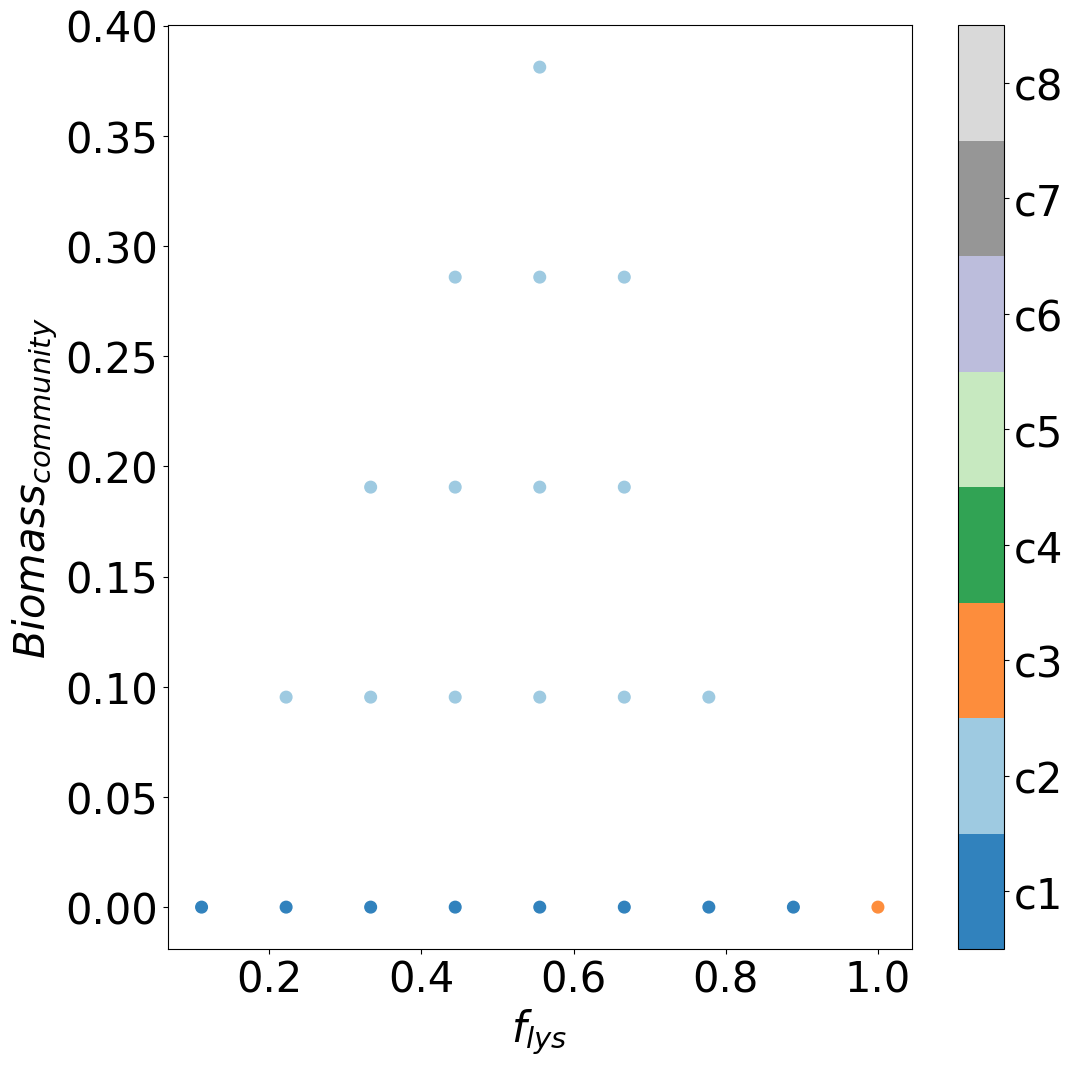

In [31]:
eco2.plot_2D_slice(prefixes=[], fixed_values=[], parent_cmap='tab20c',s=70, figsize=(12,12), 
                         to_plot = 'cluster', show_edge=False,frac_prefix= None,
                            xlabel = '$f_{lys}$',
                            ylabel ='$Biomass_{community}$')

Qualitative changes in this system are associated with increased biomass production and changes in community composition. For instance structural plasticity (-0) of organism 1 is gradually replaced by flux plasticity (--) while increasing biomass requirements.

To search for reactions that change their qualitative values between two clusters:

**1. Select representative values for each reaction on each cluster**:

The function **get_cluster_reaction_values** gives a DataFrame where each column is a cluster and each row a reaction. For each reaction it stores its representative value (for each cluster), in other words a qualitative vaues that represts over a threshold fraction of the points of the cluster. If there are no enough points in a cluster where a certain qualitative state is exhibited the cell is filled with a *NaN* value.
    
Parameters of **get_cluster_reaction_values**:
- **thr**:  Minimum fraction of cluster points where a reaction should have the same qualitative state to be considered representative (default value: 0.75) 
- **changing**: Fill the DataFrame only with reactions which representative values are different in at least 2 clusters (default: True).
    
**2. Select reactions with qualitative representative values between two clusters:**    
  
The function **compare_clusters** gives a DataFrame with reactions and their status that change between two specific clusters.

Parameters **get_cluster_reactions**:
- **cluster_df**: DataFrame generated by  **get_cluster_reaction_values**
- **cid1, cid2**: Ids of clusters to be compared


In [32]:
df = eco2.get_cluster_reaction_values(thr=0.8, changing= True)

In [33]:
df = eco2.get_cluster_reaction_values(thr=0.8, changing= True)
cat_dict = {-3.0: '-', -2.0: '--',-1.0: '-0',1.0: '0+',0.0: '0',2.0: '++',3.0: '+',4.0: '-+',5.0: 'err',100.0: 'var'}
df = df.replace(cat_dict)
df

,c1,c2,c3,c4,c5,c6,c7,c8
EX_12ppd__R_e,0+,0+,0+,NaN,NaN,NaN,NaN,NaN
EX_15dap_e,0+,0+,0,NaN,NaN,NaN,NaN,NaN
EX_4abut_e,0+,0+,0+,NaN,NaN,NaN,NaN,NaN
EX_4hba_c,0,+,0,NaN,NaN,NaN,NaN,NaN
EX_5dglcn_e,0+,0+,0+,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
eco_lys_ZN2abcpp,0+,0+,0+,NaN,NaN,NaN,NaN,NaN
eco_lys_ZN2t3pp,0+,0+,0+,NaN,NaN,NaN,NaN,NaN
eco_lys_ZN2tpp,0+,0+,0+,NaN,NaN,NaN,NaN,NaN
eco_lys_ZNabcpp,0+,0+,0+,NaN,NaN,NaN,NaN,NaN


For example, if we want to compare what are cualitative changes that occur between shifting from one cluster to another (cluster 3 and cluster 4):

In [34]:
df_comp = eco2.compare_clusters(df, 'c3','c4')

df_comp

,c3,c4
EX_12ppd__R_e,0+,NaN
EX_15dap_e,0,NaN
EX_4abut_e,0+,NaN
EX_4hba_c,0,NaN
EX_5dglcn_e,0+,NaN
...,...,...
eco_lys_ZN2abcpp,0+,NaN
eco_lys_ZN2t3pp,0+,NaN
eco_lys_ZN2tpp,0+,NaN
eco_lys_ZNabcpp,0+,NaN


# Functional relationship analysis

In [35]:
grid_x = [0.3, 0.5, 0.7]
grid_y = reversed([0.1, 0.2])
rxns_analysis = ['eco_lys_EX_lys__L_e', 'eco_leu_EX_lys__L_e']
eco2.quan_FCA(grid_x, grid_y, rxns_analysis)

Quantitative Flux Coupling analysis 
 Initializing grid...
the closest point to [0.3, 0.2] is [0.33333333 0.19057665], at a distance of 0.0346397271799492
the closest point to [0.5, 0.2] is [0.44444444 0.19057665], at a distance of 0.05634908465163052
the closest point to [0.7, 0.2] is [0.66666667 0.19057665], at a distance of 0.0346397271799492
the closest point to [0.3, 0.1] is [0.33333333 0.09528832], at a distance of 0.03366468488057865
the closest point to [0.5, 0.1] is [0.44444444 0.09528832], at a distance of 0.055754996637825856
the closest point to [0.7, 0.1] is [0.66666667 0.09528832], at a distance of 0.03366468488057865
Read LP format model from file /tmp/tmpre9rndcm.lp
Reading time = 0.02 seconds
: 3640 rows, 10136 columns, 38748 nonzeros
Read LP format model from file /tmp/tmpf50k0rqp.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Read LP format model from file /tmp/tmpwvr8i7jv.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonze

/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmpl3c3uy8j.lp
Reading time = 0.02 seconds
: 3640 rows, 10136 columns, 38748 nonzeros
Read LP format model from file /tmp/tmpem9n0kmp.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Read LP format model from file /tmp/tmp1ngrh7c8.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Selected point[0.44444444 0.19057665]
This point coords [0.44444444 0.19057665]
This point frac [np.float64(0.4444444444444444), np.float64(0.5555555555555556)]
Old grid point [np.float64(0.08470073185314048), np.float64(0.10587591481642561)]


/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmplbq2rcuw.lp
Reading time = 0.02 seconds
: 3640 rows, 10136 columns, 38748 nonzeros
Read LP format model from file /tmp/tmpx_ob4v7p.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Read LP format model from file /tmp/tmpl6p0tzlm.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Selected point[0.66666667 0.19057665]
This point coords [0.66666667 0.19057665]
This point frac [np.float64(0.6666666666666666), np.float64(0.33333333333333337)]
Old grid point [np.float64(0.12705109777971071), np.float64(0.06352554888985537)]


/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmpn577qofq.lp
Reading time = 0.02 seconds
: 3640 rows, 10136 columns, 38748 nonzeros
Read LP format model from file /tmp/tmp_r244jh9.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Read LP format model from file /tmp/tmplrxeh7xa.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Selected point[0.33333333 0.09528832]
This point coords [0.33333333 0.09528832]
This point frac [np.float64(0.3333333333333333), np.float64(0.6666666666666667)]
Old grid point [np.float64(0.03176277444492768), np.float64(0.06352554888985537)]


/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmp3v7fyscl.lp
Reading time = 0.02 seconds
: 3640 rows, 10136 columns, 38748 nonzeros
Read LP format model from file /tmp/tmphwguml8w.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Read LP format model from file /tmp/tmp7i49104g.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Selected point[0.44444444 0.09528832]
This point coords [0.44444444 0.09528832]
This point frac [np.float64(0.4444444444444444), np.float64(0.5555555555555556)]
Old grid point [np.float64(0.04235036592657024), np.float64(0.052937957408212805)]


/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmp06gblrtj.lp
Reading time = 0.02 seconds
: 3640 rows, 10136 columns, 38748 nonzeros
Read LP format model from file /tmp/tmp7zfdj8ut.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Read LP format model from file /tmp/tmp4z9wobig.lp
Reading time = 0.01 seconds
: 1668 rows, 4764 columns, 18462 nonzeros
Selected point[0.66666667 0.09528832]
This point coords [0.66666667 0.09528832]
This point frac [np.float64(0.6666666666666666), np.float64(0.33333333333333337)]
Old grid point [np.float64(0.06352554888985536), np.float64(0.031762774444927686)]


/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

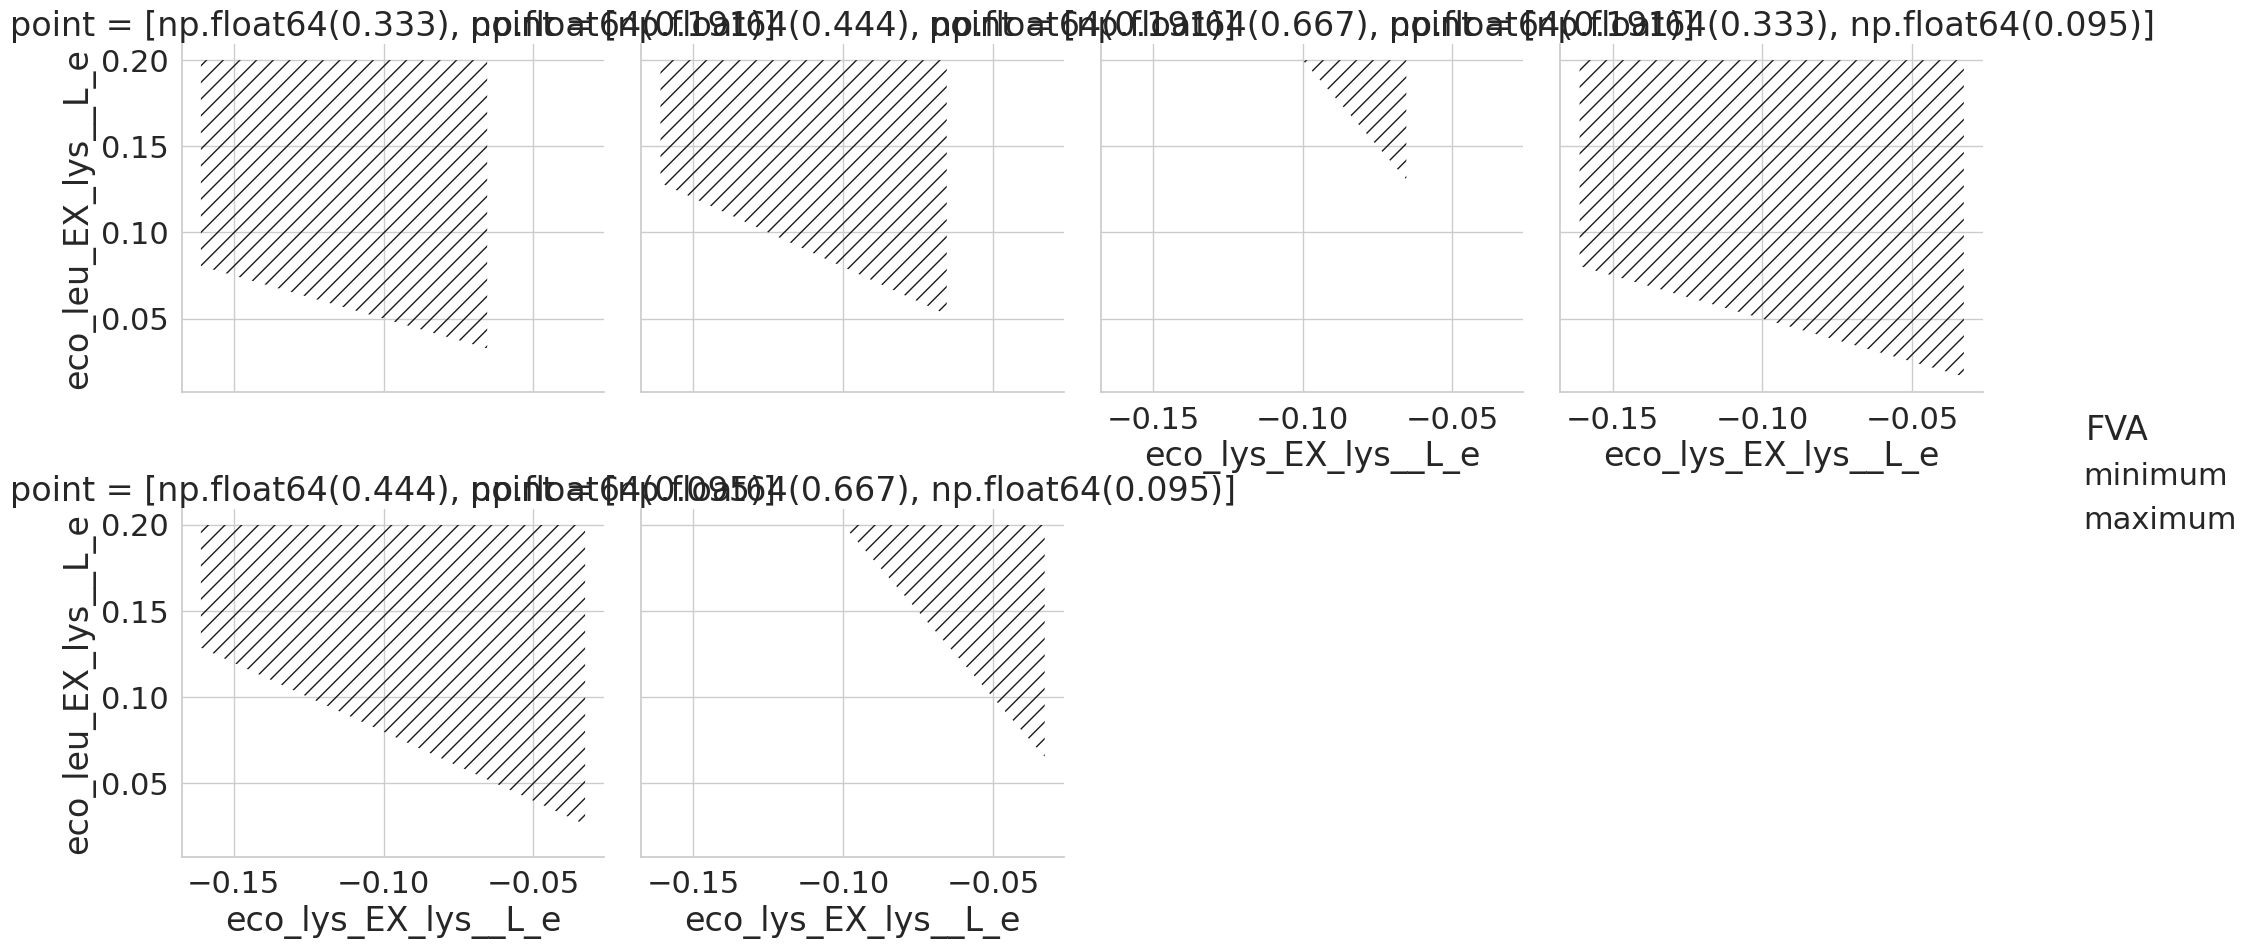

In [36]:
eco2.plot_qFCA()